In [ ]:
# getting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**loading dataset**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# checking for CUDA
if torch.cuda.is_available():
  print("GPU !")
else:
  print("CPU !")

GPU !


In [ ]:
# dataset path
# without pre-processing
# data_path = "/content/drive/MyDrive/Leukemia/clahe_train"
data_path = "/content/drive/MyDrive/Leukemia/hsv_aug_s"

In [ ]:
# defining transformation
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

transforms = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.RandomHorizontalFlip(p=0.25),
    # transforms.RandomVerticalFlip(p=0.25),
    # transforms.RandomRotation((0,180)),
    # transforms.CenterCrop(150),
    # transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
                        ])

In [ ]:
# performing transforming into our dataset
dataset = torchvision.datasets.ImageFolder(root= data_path, transform= transforms)

In [ ]:
print("Total number of samples: ", len(dataset))

Total number of samples:  20000


In [ ]:
# splitting dataset and visualize
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
num_workers = 0
batch_size = 16

# obtain training indices that will be used for validation
valid_size= 0.2 # taking 20% data as our test set
num_data = len(dataset)
indices = list(range(num_data))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_data))
train_idx, test_idx = indices[split:], indices[:split]

print('After splitting train data: ',len(train_idx))
print('After splitting test data: ',len(test_idx))

# define samplers for obtaining training and test batches
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=test_sampler, num_workers=num_workers)
# image classes
classes = ['HEM', 'ALL']

After splitting train data:  16000
After splitting test data:  4000


In [ ]:
%matplotlib inline

# helper function to display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

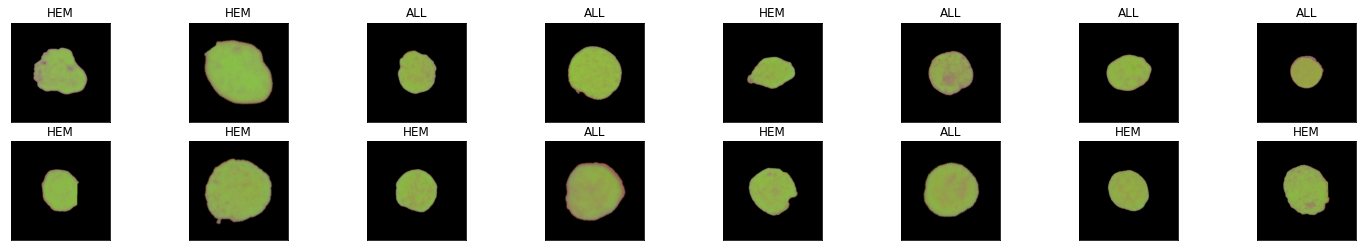

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.__next__()
images = images.numpy() # Converted Image to numpy

# plot the images in the batch, along with the corresponding labels

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [ ]:
images[1].shape

(3, 224, 224)

In [ ]:
# Taking vgg19 model
from torchvision import models
vgg19 = models.vgg19(weights='IMAGENET1K_V1')  #pretrained=True

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# change the number of classes
vgg19.classifier[2] = nn.Dropout(p= 0.5, inplace= False)
vgg19.classifier[3] = nn.Linear(4096, 1024)
vgg19.classifier[5] = nn.Dropout(p= 0.25, inplace= False)
vgg19.classifier[6] = nn.Linear(1024, 2)

# freeze convolution weights
for param in vgg19.features.parameters():
    param.requires_grad = False

In [ ]:
# defining modified vgg 19 as our model
model = vgg19
# moving model to GPU
if torch.cuda.is_available():
  model.cuda()

In [ ]:
from torchvision import models
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
import torch.optim as optim
# optimizer
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9, weight_decay= 5e-4 ) #weight_decay= 5e-4
# optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001, betas= (0.9, 0.999), eps= 1e-8, weight_decay=0)
# loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
# train for some epochs
# number of epochs to train the model
n_epochs = 5

# using test set as validation set
valid_loader = test_loader

valid_loss_min = np.Inf # track change in validation loss

valid_list= []  # stores validation losses
train_list= []  # stores train losses

valid_acc = [] # store validation accuracy
train_acc = [] # store train accuracy

for epoch in range(1, n_epochs+1):

    # keep track of training, validation loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    train_corrects = 0
    val_corrects = 0

    # trianing the model
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data)
        _,preds = torch.max(output, 1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        train_corrects += torch.sum(preds == target.data)


    # validate the model
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        output = model(data)
        _,preds = torch.max(output, 1)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        val_corrects += torch.sum(preds == target.data)

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    # calculate accuracy
    t_acc = train_corrects/len(train_loader.sampler)
    v_acc = val_corrects/len(valid_loader.sampler)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTrain Acc: {:4f} \tValidation Acc: {:4f}'.format(
        epoch, train_loss, valid_loss, t_acc, v_acc))

    # Using Schedular step
    # scheduler.step()

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), '/content/drive/MyDrive/Leukemia/label_noise/lk_final_20k_hsv_vgg19.pt')
        valid_loss_min = valid_loss

    #storing train and validation looses
    train_list.append(train_loss)
    valid_list.append(valid_loss)
    # storing train and validartion accuracy
    train_acc.append(t_acc)
    valid_acc.append(v_acc)

Epoch: 1 	Training Loss: 0.281863 	Validation Loss: 0.401467 	Train Acc: 0.877875 	Validation Acc: 0.842250
Validation loss decreased (inf --> 0.401467).  Saving model ...
Epoch: 2 	Training Loss: 0.269601 	Validation Loss: 0.388399 	Train Acc: 0.883875 	Validation Acc: 0.832750
Validation loss decreased (0.401467 --> 0.388399).  Saving model ...
Epoch: 3 	Training Loss: 0.263427 	Validation Loss: 0.376024 	Train Acc: 0.886938 	Validation Acc: 0.848500
Validation loss decreased (0.388399 --> 0.376024).  Saving model ...
Epoch: 4 	Training Loss: 0.260474 	Validation Loss: 0.383400 	Train Acc: 0.889188 	Validation Acc: 0.846000
Epoch: 5 	Training Loss: 0.258459 	Validation Loss: 0.372208 	Train Acc: 0.889688 	Validation Acc: 0.849750
Validation loss decreased (0.376024 --> 0.372208).  Saving model ...


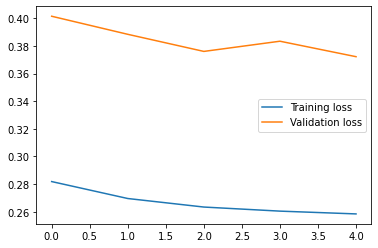

In [ ]:
# plotting the training and validation loss
plt.plot(train_list, label='Training loss')
plt.plot(valid_list, label='Validation loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/Leukemia/pre_processing_experiments/validation_curv_org_aug_20k.png', dpi=300)
plt.show()

In [ ]:
train_acc = torch.tensor(train_acc, device= 'cpu')
valid_acc = torch.tensor(valid_acc, device= 'cpu')

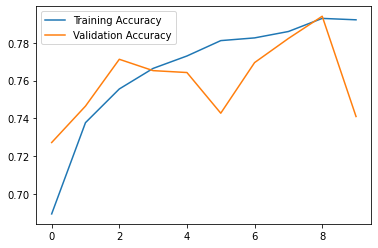

In [ ]:
# plotting the training and validation accuracy
plt.plot(train_acc.cpu(), label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/Leukemia/pre_processing_experiments/validation_acc_org_aug_20k.png', dpi=300)
plt.show()

In [ ]:
# load best model
model.load_state_dict(torch.load('/content/drive/MyDrive/Leukemia/label_noise/lk_final_20k_hsv_vgg19.pt'))

<All keys matched successfully>

In [ ]:
n_corrects= 0
n_samples= 0

y_test = []
prediction = []
model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    label = target.detach().cpu().numpy()
    y_test.append(label)
    _, pred = torch.max(output, 1)
    prediction.append(pred.detach().cpu().numpy())
    n_corrects += (pred== target).sum().item()
    n_samples += target.size(0)

print(f'Overall accuracy {(n_corrects / n_samples)*100}%')

Overall accuracy 84.975%


In [ ]:
print("single batch labels: ", y_test[1])
print("single batch prediction: ", prediction[1])

single batch labels:  [0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0]
single batch prediction:  [0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0]


In [ ]:
# import chain
from itertools import chain
# converting 2d list into 1d
# using chain.from_iterables
y_test_1 = list(chain.from_iterable(y_test))

In [ ]:
# for predictions
prediction_1 = list(chain.from_iterable(prediction))

In [ ]:
#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test_1, prediction_1)
print ("Accuracy = ", round(acc, 3))

Accuracy =  0.85


In [ ]:
# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test_1, prediction_1)
print("ROC-AUC score is: ", round(roc_auc, 3))

ROC-AUC score is:  0.85


In [ ]:
# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test_1, prediction_1)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

The Matthews correlation coefficinet (MCC) is:  0.7


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_1, prediction_1))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1936
           1       0.87      0.84      0.85      2064

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



In [ ]:
# !pip install imblearn

In [ ]:
# specificity
from imblearn.metrics import specificity_score
sp = specificity_score(y_test_1, prediction_1, average='weighted')
sp_1 = specificity_score(y_test_1, prediction_1, average='micro')
sp_2 = specificity_score(y_test_1, prediction_1, average='macro')

In [ ]:
print(f"Macro specificity: {sp_2}")
print(f"Micro specificity: {sp_1}")
print(f"Weighted specificity: {sp}")

Macro specificity: 0.8502286341213403
Micro specificity: 0.84975
Weighted specificity: 0.8507072682426805
